In [1]:
from functools import reduce, partial
from itertools import repeat, product, combinations, chain
from operator import or_, add, itemgetter, attrgetter
from random import randint
from collections import deque, defaultdict
from enum import Enum

import cv2
import numpy as np
from numpy import (array,
                   flip,
                   zeros_like,
                   dot,
                   subtract,
                   multiply,
                   divide,
                   arange,
                   sign)
from numpy.linalg import norm

from matplotlib.pyplot import imshow, figure, subplots
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d.axes3d import Axes3D
# pylint: disable=undefined-variable
%matplotlib inline

## Morphing

In [2]:
def cross(shape):
    return cv2.getStructuringElement(cv2.MORPH_CROSS, shape)

def circle(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))

def cvclose(image, kernel):
    return cv2.erode(cv2.dilate(image, kernel), kernel)

def constant_border(image, length, value):
    return cv2.copyMakeBorder(image, length, length, length, length, cv2.BORDER_CONSTANT, value=value)

# m-adjacent neighbors

 For a given image $I$ and a mask $M$, pixel $p, q$ are
 considered m-adjacent if one of the following is true

  1. $q$ is a 4-adjcent of $p$ where $p,q\in M$
  2. $q$ is diagonal of $q$ where $p, q\in M$ *and*
     there is no $\omega\in M$ where $\omega$
     is both 4-adjecent of $p$ and 4-adjecent of $q$


In [3]:
def is_in_image(pixel, shape):
    r, c = pixel
    rows, cols = shape
    return ((0 <= r < rows) and
            (0 <= c < cols))

def adjesent_m(pixel, mask):
    def is_in(pixel):
        r, c = pixel
        return is_in_image((r, c), mask.shape) and mask[r, c]

    def add_offset(offset):
        return tuple(map(add, pixel, offset))

    neighbors_4 = [offset
                   for offset in [(1, 0), (0, 1), (-1, 0), (0, -1)]
                   if is_in(add_offset(offset))]

    neighbors_diag = [(o_r, o_c)
                      for o_r, o_c in [(1, 1), (-1, 1), (-1, -1), (1, -1)]
                      if set([(0, o_r), (o_c, 0)]).isdisjoint(neighbors_4) and is_in(add_offset((o_r, o_c)))]

    return [add_offset(offset) for offset in neighbors_4 + neighbors_diag]

## Convertions

In [4]:
def uint8(image):
    return image.astype(np.uint8)

def arrayuint8(rows):
    return uint8(array(rows))

## Display

In [5]:
def as_display(image):
    if image.shape[-1] == 3:
        return image

    return cv2.cvtColor(cv2.normalize(image.astype(np.float),
                                      None,
                                      0,
                                      255,
                                      cv2.NORM_MINMAX).astype(np.uint8),
                        cv2.COLOR_GRAY2RGB)

def rand_color():
    return (randint(150, 200), randint(150, 200), randint(0, 255))

def show_lines(image, lines, colors, width=1):
    image_with_lines = as_display(image)
    for ((point1, point2), color) in zip(lines, colors):
        cv2.line(image_with_lines, point1, point2, color, width)

    return image_with_lines

def show_points(image, points, radius=2):
    image_with_circles = as_display(image)
    randcolor = (100, randint(150, 200), randint(0, 255))
    for point in points:
        cv2.circle(image_with_circles, point, radius, randcolor, thickness=-1)
    return image_with_circles

def figure_image(figsize=(15, 15), **kwargs):
    return figure(figsize=figsize, **kwargs)

def plot_lines_3d(lines, colors, **kwargs):
    _, axes = subplots(subplot_kw={'projection': '3d'}, **kwargs)
    axes.set_zlim3d(0, 2)
    for (x, y, z), color in zip(lines, colors):
        axes.plot(x, y, z, color=color)

def plot_surface(shape, z):
    fig = figure(figsize=(15, 7))
    axes = fig.gca(projection='3d')

    xgrid, ygrid = np.meshgrid(*(arange(0, coord, 1) for coord in shape))
    zgrid = z(xgrid, ygrid)
    axes.plot_surface(xgrid, ygrid, zgrid,
                      cmap="coolwarm",
                      linewidth=0,
                      antialiased=True)

    axes.set_zlim3d(0, 2)
    axes.zaxis.set_major_locator(LinearLocator(10))
    axes.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))


# Input

We get a text document as input

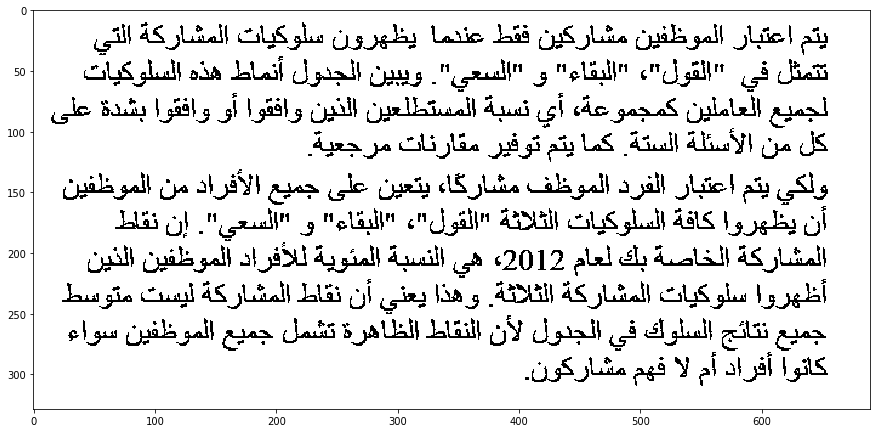

In [6]:
TEXT = cv2.threshold(src=cv2.imread("arabic.jpg", cv2.IMREAD_GRAYSCALE),
                     thresh=200,
                     maxval=1,
                     type=cv2.THRESH_BINARY)[1]

imshow(TEXT, cmap='gray', figure=figure_image())

# Ducument preprocessing
We erode input to emphasize words and add a black border to force graph edges at picture sides

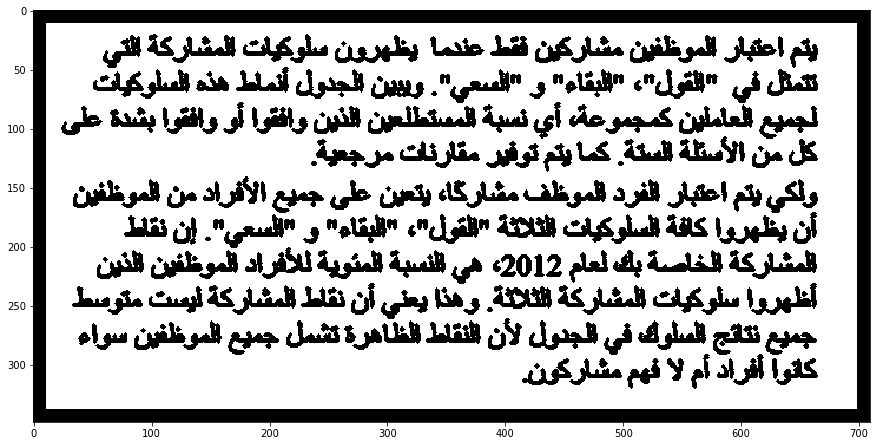

In [7]:
TEXT_SHOW = constant_border(TEXT, 10, 1)
TEXT_ERODE = cv2.erode(constant_border(TEXT, 10, 0), circle(3))
imshow(TEXT_ERODE, cmap='gray', figure=figure_image())

# Distance transform

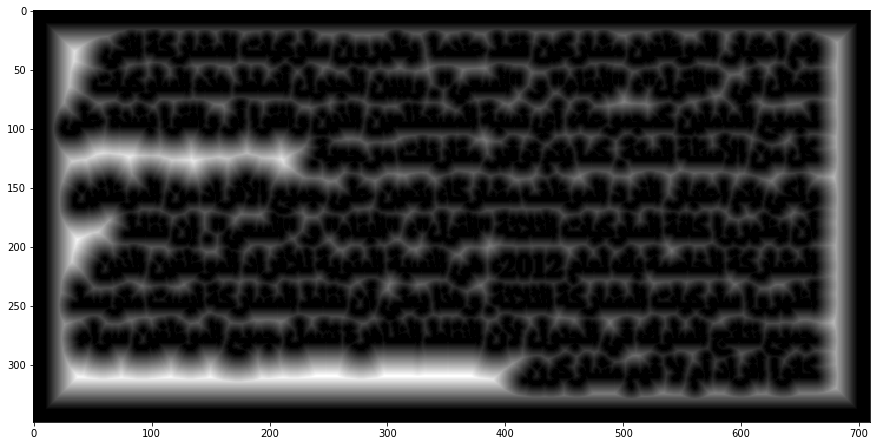

In [8]:
DIST = cv2.distanceTransform(TEXT_ERODE, cv2.DIST_L2, cv2.DIST_MASK_5)
imshow(DIST, cmap='gray', figure=figure_image())

# Local maxima

Each pixel $p$ is consider local maximum if $p > q_1 \wedge p> q_2$ where $q_1, q_2$ are opposite pixels in the 8-member inviroment of $p$

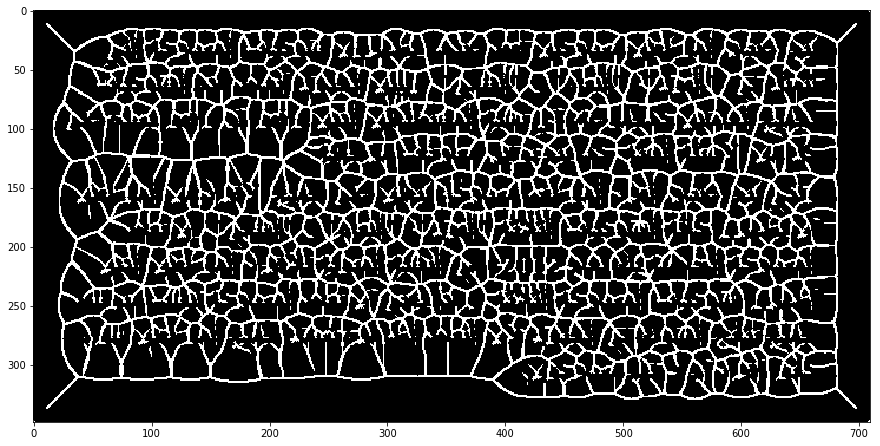

In [9]:
def local_maxima(image):

    horizontals = list(map(arrayuint8, [
        [
            [0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0]
        ],
        [
            [0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0]
        ],
    ]))

    horizontals_fliped = [flip(mat, 1) for mat in horizontals]


    kernels = [mat
               for matrices in [(mat, mat.T) for mat in horizontals + horizontals_fliped]
               for mat in matrices]

    local_maximas = (image > cv2.dilate(image, kernel)
                     for kernel in kernels)

    return uint8(reduce(or_, local_maximas))

LOCAL_DIST_MAXIMA = local_maxima(DIST)

imshow(LOCAL_DIST_MAXIMA, cmap='gray', figure=figure_image())

# Graph

We extract the vertices and the edges from the local maxima matrix

## Junction pixels

Using erode, we find juntions checking various predefined shapes.

e.g

Given the following shape,


$\begin{pmatrix}0&0&0&0&0\\0&0&0&0&0\\1&1&\textbf{p}&1&1\\0&0&1&0&0\\0&0&1&0&0 \end{pmatrix}$

If the shape exists in distmap local maxima (meaning all if the shape pixels are $1$), the pixel $p$ is a junciton pixel.

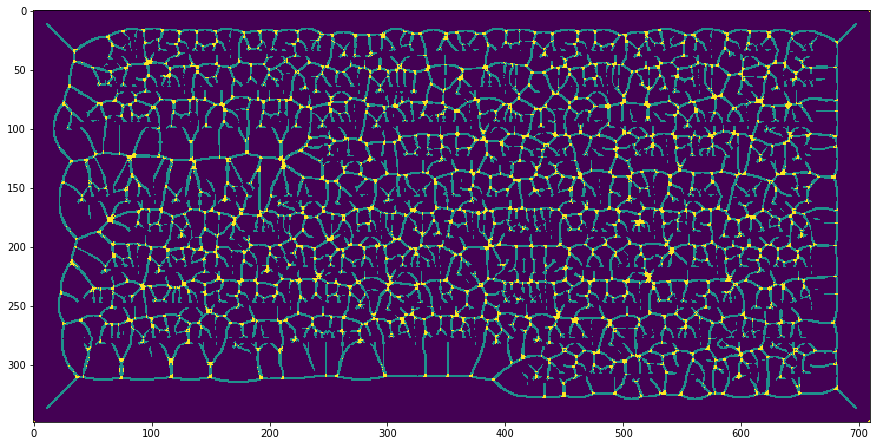

In [10]:
def rotations(mat):
    return (mat, mat.T, flip(mat, 0), flip(mat.T, 1))

def mark_junction_pixels(binary):
    junctions = map(arrayuint8, [
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 1, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1],
            [0, 0, 0, 1, 0],
            [1, 1, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 0],
            [0, 1, 0, 0, 0],
            [0, 0, 1, 1, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [1, 0, 0, 0, 1],
            [0, 1, 0, 1, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ],
        [
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0],
            [1, 1, 1, 1, 1],
            [1, 0, 1, 0, 1],
            [0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0],
        ]
    ])

    rotated_mats = (rotated
                    for mat in junctions
                    for rotated in rotations(mat))

    def filter_junction(junction):
        return cv2.erode(binary, junction)

    return reduce(or_, map(filter_junction, rotated_mats), zeros_like(binary))

imshow(LOCAL_DIST_MAXIMA + mark_junction_pixels(LOCAL_DIST_MAXIMA),
       figure=figure_image())

## Vertices
We define vertices as centeroids of each connected component of juntion pixels

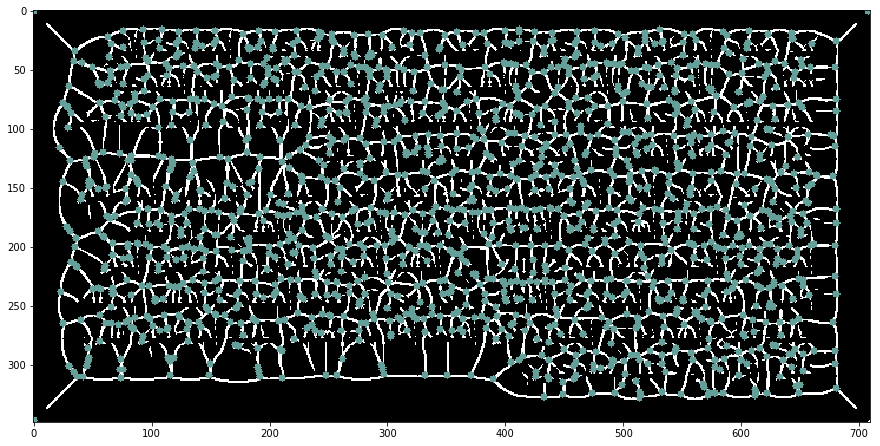

In [11]:
def extract_vertices(junction_pixels):
    _, labels, _, centeroids = cv2.connectedComponentsWithStats(
        junction_pixels,
        connectivity=4
    )
    return ([tuple(map(int, point)) for point in centeroids[1:-1]],
            labels - 1)


LOCAL_MAX_VERTS, LABELS = extract_vertices(mark_junction_pixels(LOCAL_DIST_MAXIMA))
imshow(show_points(LOCAL_DIST_MAXIMA, LOCAL_MAX_VERTS, 3),
       figure=figure_image())

 # Edges

## BFS
* We define set $V=$ [vertices](#vertices)
* While $V\neq \emptyset$
  - Start from some $v \in V$ and set $V = V - \{v\}$
  - Perform a $BFS$ scan on [local maxima](#Local-maxima) starting from $v$ iterating m-adjecent neighbors
  - Add all found neighbors of $v$ into the graph as vonnected to $v$

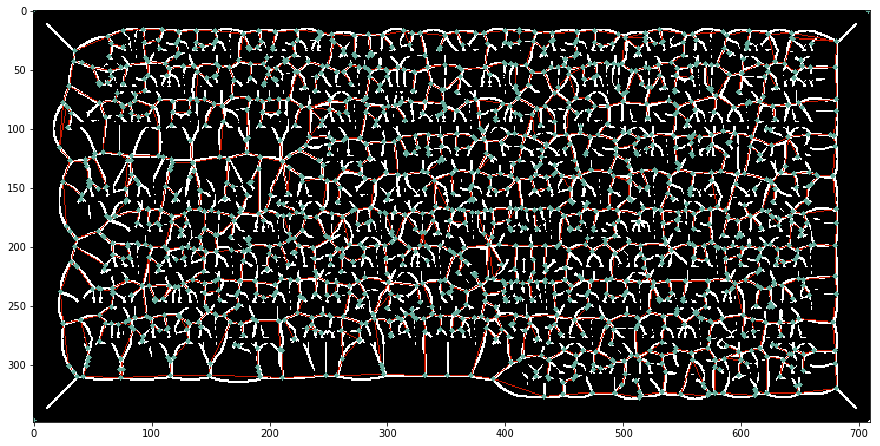

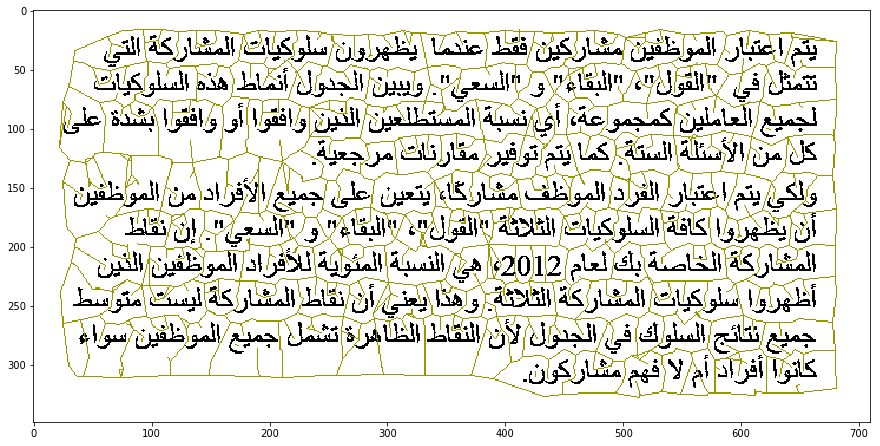

In [12]:
def area_to_vert(verts, radius):
    return dict((point, (x, y))
                for (x, y) in verts
                for point in product(range(x - radius, x + radius),
                                     range(y - radius, y + radius)))

def pixel_vert(pos, verts, labels_map, area_map):
    row, col = pos
    label = labels_map[row, col]
    if 0 <= label < len(verts):
        return verts[label]
    else:
        return area_map.get(pos)

def mask_connected(start, search_mask, covermap):
    visited = set()
    bfs_q = deque([start])

    while bfs_q:
        pos = bfs_q.popleft()
        vert = covermap(pos) or start
        if start == vert:
            nextvs = [v for v in adjesent_m(pos, search_mask) if v not in visited]
            visited.update(nextvs)
            bfs_q.extend(nextvs)
        else:
            yield vert

def build_graph(verts, find_connected_verts):
    edges = ((v1, v2)
             for v1 in verts
             for v2 in find_connected_verts(v1))

    graph = defaultdict(set)

    for v1, v2 in edges:
        graph[v1].add(v2)
        graph[v2].add(v1)

    return graph

def remove_verts(graph, rmverts):
    for vert in rmverts:
        graph.pop(vert)

    graph.update((vert, neighbors - rmverts)
                 for vert, neighbors in graph.items())

def graph_edges(graph):
    return set(tuple(sorted(((c1, r1), (c2, r2))))
               for (r1, c1), connecetd in graph.items()
               for (r2, c2) in connecetd)


def graph_vertices(graph):
    return graph.keys()

ROW_INDEX_VERTS = [(c, r) for r, c in LOCAL_MAX_VERTS]

GRAPH = build_graph(
    verts=set(ROW_INDEX_VERTS),
    find_connected_verts=partial(mask_connected,
                                 search_mask=LOCAL_DIST_MAXIMA,
                                 covermap=partial(
                                     pixel_vert,
                                     labels_map=LABELS,
                                     verts=ROW_INDEX_VERTS,
                                     area_map=area_to_vert(ROW_INDEX_VERTS, 4)
                                 )))

imshow(
    show_points(
        show_lines(
            LOCAL_DIST_MAXIMA,
            graph_edges(GRAPH),
            repeat((200, 24, 0)),
            width=1),
        LOCAL_MAX_VERTS, 2),
    figure=figure_image())

imshow(show_lines(TEXT_SHOW, graph_edges(GRAPH), repeat((150, 150, 0))),
       figure=figure_image())

# Dilute to 3-connected

Until we get a graph where all it's vertices have at least 3 neighbors, we rebuild the graph by find all 3 connected neighbors for vertice with at least 3 neighbors.

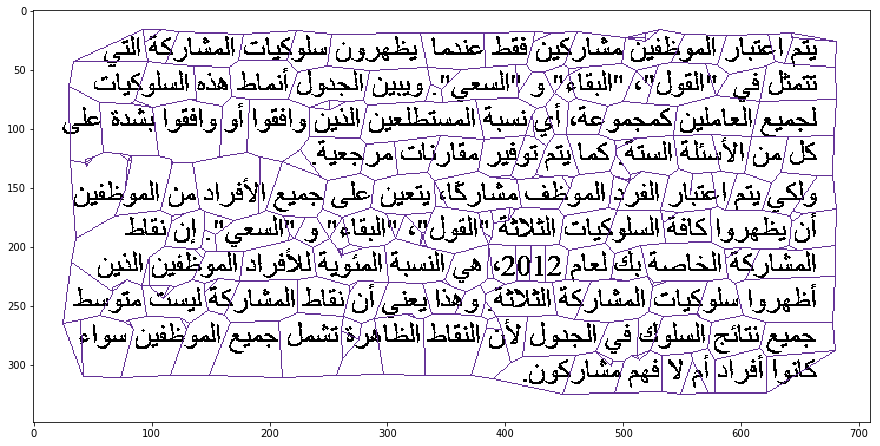

In [13]:
def graph_connected(start, graph):
    visited = set()
    bfs_q = deque([start])

    while bfs_q:
        vs = [(v, len(graph[v])) for v in graph[bfs_q.popleft()]
              if v not in visited and v != start]
        nextvs = [v for v, n_vs in vs if n_vs <= 2]
        visited.update(nextvs)
        bfs_q.extend(nextvs)

        for v in [v for v, n_vs in vs if n_vs > 2]:
            yield v

def dilute_to_3_connected(graph):
    graph3 = graph.copy()
    while True:
        verts3 = [v for v, n_vs in graph3.items() if len(n_vs) > 2]

        if len(verts3) == len(graph3.keys()):
            return graph3

        graph3 = build_graph(
            verts=verts3,
            find_connected_verts=partial(graph_connected, graph=graph3))

GRAPH_3 = dilute_to_3_connected(GRAPH)

imshow(show_lines(TEXT_SHOW, graph_edges(GRAPH_3), repeat((100, 50, 150))),
       figure=figure_image())

# Edge classification

## T juncitons
We use fuzzy logic to determin if a vertex is of a T juntion.

For any vertex $v_0$ with 3 neighbors $v_1, v_2, v_3$ Let
$VS=\{\vec{v_0v_1}, \vec{v_0v_2}, \vec{v_0v_3}\}$ And let $\theta_1, \theta_2, \theta_3$ be angles between each two vector pair $\vec{\tilde{v_1}}, \vec{\tilde{v_2}} \in VS$

We check how much each angle is close to $90^{\circ}$ by calculating
$\frac{\tilde{v_1}\cdot\tilde{v_2}}{\Vert\tilde{v_1} \rVert\Vert\tilde{v_2} \rVert} = \cos(\theta)$ and seeing how close to zero it is.

The juntion grade is the second closest angle to $90^{\circ}$ out of $\theta_1\dots \theta_3$ (for a perfect T juntion, we expect angles $90^{\circ}, 90^{\circ}, 180^{\circ}$)

In [14]:
def vcos(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2))

def t_grade(v, vs):
    if len(vs) != 3:
        return (0, None)

    vectors = (subtract(v2, v) for v2 in vs)
    cosines = (((v1, v2), abs(vcos(v1, v2))) for v1, v2 in combinations(vectors, 2))
    sorted_grades = sorted(cosines, key=itemgetter(1))

    sorted_pairs = [tuple(map(tuple, v)) for v, _ in sorted_grades]

    linear_grade = 1 - sorted_grades[1][1]
    graded_vec = set(sorted_pairs[0]).intersection(sorted_pairs[1]).pop()

    if graded_vec[0]:
        graded_vec = multiply(sign(graded_vec[0]), graded_vec)
    elif graded_vec[1]:
        graded_vec = multiply(sign(graded_vec[1]), graded_vec)

    graded_vec = divide(graded_vec, norm(graded_vec))
    return (linear_grade ** 2, graded_vec)

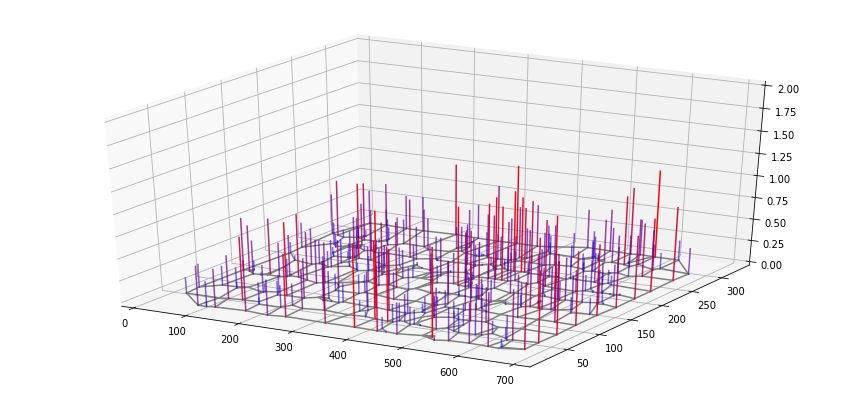

In [15]:
def plot_t_juncitons(edges, t_grades):
    t_grades = list(t_grades)
    graph_lines_3D = list(tuple(zip(*edge)) + ((0, 0),) for edge in edges)
    tgrades_lines_3d = list(((vy, vy), (vx, vx), (0, grade)) for (vx, vy), grade in t_grades)

    plot_lines_3d(
        chain(graph_lines_3D,
              tgrades_lines_3d),
        chain(repeat("gray", len(graph_lines_3D)),
              ((grade, 0, 1 - grade, 0.5 + grade / 2)
               for _, grade in t_grades)),
        figsize=(15, 7))

plot_t_juncitons(graph_edges(GRAPH_3),
                 ((v, t_grade(v, vs)[0]) for v, vs in GRAPH_3.items()))

## Center pixels
we want to eliminate pixels at the edges of the pictures therefore we use a fuzzy set $Center$

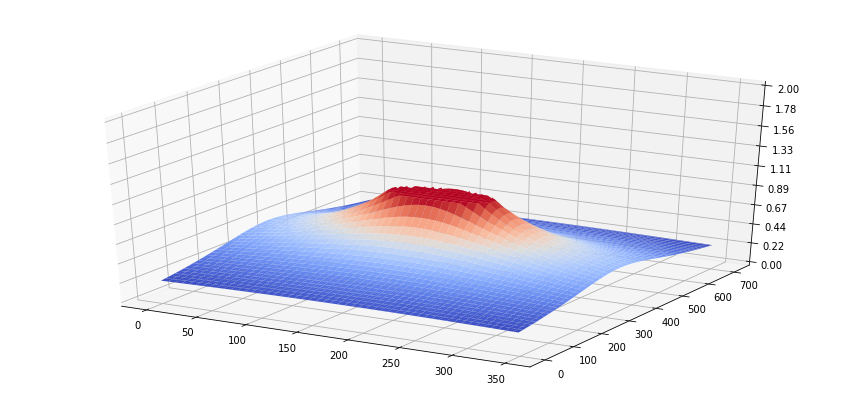

In [16]:
def center_fuzzy_set(x, y, shape):
    max_x, max_y = shape
    delta = 0.01

    def f(coord):
        return (delta * coord) ** 2

    R = ((x - max_x / 2)**2 + (y - max_y/2)**2)** 0.5
    return reduce(np.minimum,
                  [1,
                   1 / (0.5 + R* delta)])

plot_surface(TEXT_SHOW.shape, partial(center_fuzzy_set, shape=TEXT_SHOW.shape))

We are looking for $v$ where $v\in \textrm{T-juntion}\wedge v \in \textrm{Center-pixels}$ (performed in fuzzy sets logic)

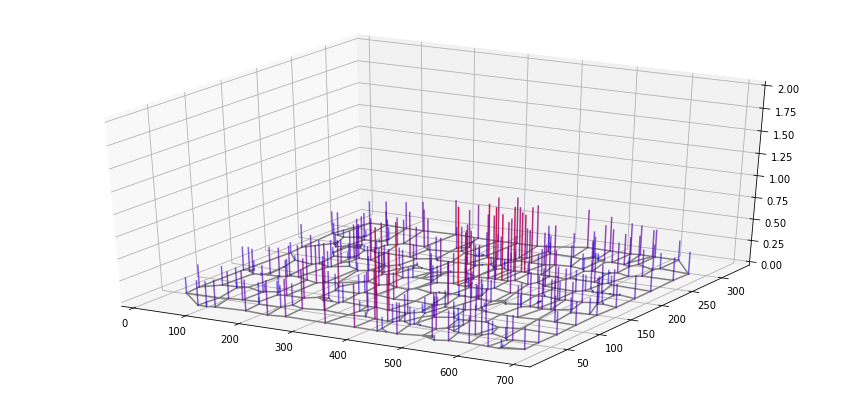

In [17]:
def centered_t_grades(graph, shape):
    t_grades = [(v, t_grade(v, vs)) for v, vs in graph.items()]
    return [((r, c), min(grade, center_fuzzy_set(r, c, shape)), grade_vec)
            for (r, c), (grade, grade_vec) in t_grades]

plot_t_juncitons(graph_edges(GRAPH_3),
                 map(itemgetter(0, 1), centered_t_grades(GRAPH_3, TEXT_SHOW.shape)))

In [18]:
def direction_vector(t_grades):
    sum_probs = sum(map(itemgetter(1), t_grades))
    mults = [multiply(grade, vec) for _, grade, vec in t_grades if vec is not None]
    return sum(mults) / sum_probs

def evaluate_direction(graph, image_shape):
    return direction_vector(centered_t_grades(graph, image_shape))[::-1]

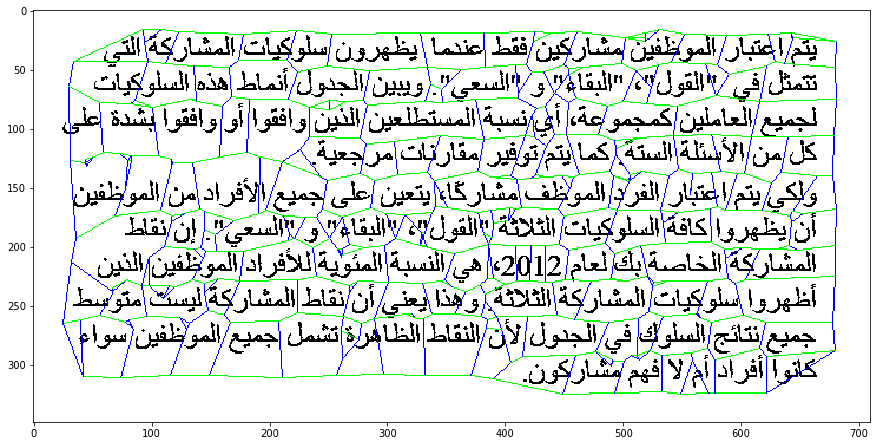

In [19]:
class EdgeType(Enum):
    BRIDGE = (0, 0, 255) # blue
    LINK = (0, 255, 0) # green

def classify_edges(graph, direction):
    return [((p1, p2),
             EdgeType.BRIDGE if abs(vcos(subtract(p2, p1), direction)) > 0.5 else EdgeType.LINK)
            for p1, p2 in graph_edges(graph)]

CLASSIFIED = classify_edges(GRAPH_3, evaluate_direction(GRAPH_3, TEXT_SHOW.shape))

imshow(show_lines(TEXT_SHOW,
                  map(itemgetter(0), CLASSIFIED),
                  map(attrgetter('value'), map(itemgetter(1), CLASSIFIED))),
       figure=figure_image())